## Cell tracking over sessions

* What percentage of cells are present across multiple sessions?
* Are these percentages/patterns affected by the drug treatment?

In [4]:
cd /home/blansdel/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import combinations, product
from collections import Counter
from scipy.stats import chi2_contingency

from src.lib import compute_stats

Load cell data

In [13]:
sessions = [2, 6, 7, 9]

fn_in = './data/input/explore.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()

Count number of cells by recording day

In [14]:
counts_by_day = np.zeros((3, 2, 4))
for i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for j, animal in enumerate(animals):
        counts_by_day[i,j] = np.sum(np.stack(list(cell_stats[animal].values())), axis = 0)

Plot number of cells recording in each day

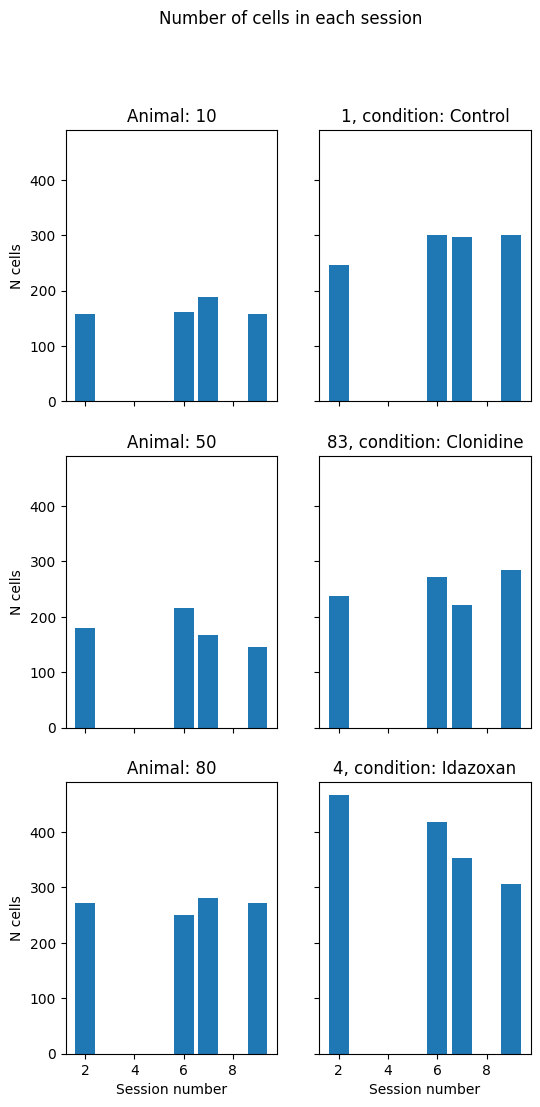

In [15]:
fig, axes = plt.subplots(3,2, figsize = (6,12), sharex = True, sharey = True)
for i,j in product(range(3), range(2)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    axes[i,j].bar(sessions, counts_by_day[i,j], label = ['2', '6', '7', '9'])
    if j == 0:
        axes[i,j].set_ylabel('N cells')
    title = f'Animal: {animals[j]}'
    if j == 1:
        title += f', condition: {conditions[i]}'
        title = title.replace('Animal: ', '')
    axes[i,j].set_title(title)
    if i == 2:
        axes[i,j].set_xlabel('Session number')
fig.suptitle("Number of cells in each session");

Plot proportion of cells that are tracked over N recordings

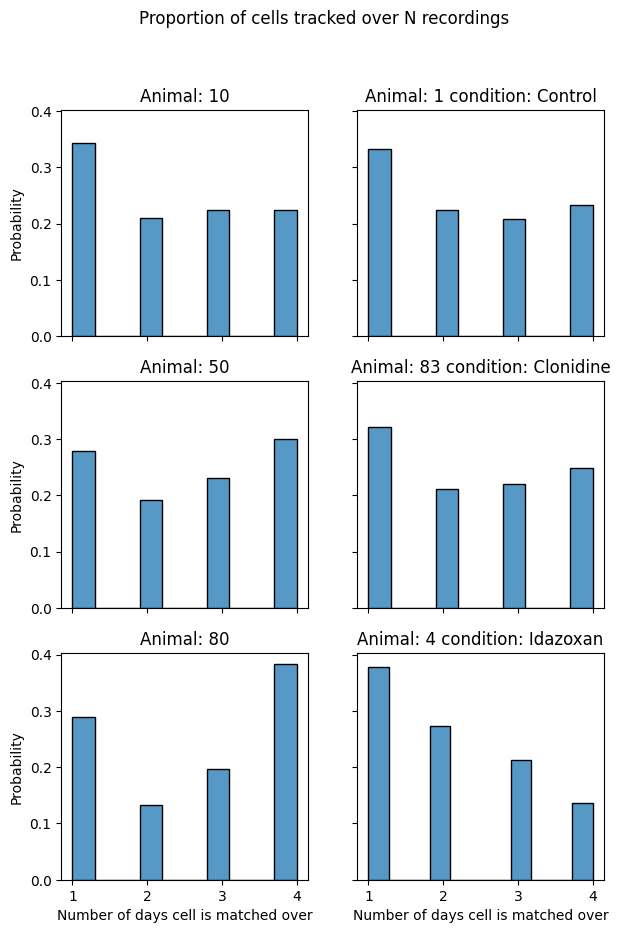

In [16]:
fig, axes = plt.subplots(3, 2, figsize = (7, 10), sharex = True, sharey = True)
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[0])
sns.histplot(cell_sums_list[animals[0]], ax = axes[0,0], stat = 'probability')
axes[0,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[0,1], stat = 'probability')
axes[0,1].set_title(f'Animal: {animals[1]} condition: {conditions[0]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[1])
sns.histplot(cell_sums_list[animals[0]], ax = axes[1,0], stat = 'probability')
axes[1,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[1,1], stat = 'probability')
axes[1,1].set_title(f'Animal: {animals[1]} condition: {conditions[1]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[2])
sns.histplot(cell_sums_list[animals[0]], ax = axes[2,0], stat = 'probability')
axes[2,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[2,1], stat = 'probability')
axes[2,1].set_title(f'Animal: {animals[1]} condition: {conditions[2]}')
axes[2,1].set_xlabel("Number of days cell is matched over")
axes[2,0].set_xlabel("Number of days cell is matched over")
fig.suptitle("Proportion of cells tracked over N recordings");

Same plot but pooling animals together:

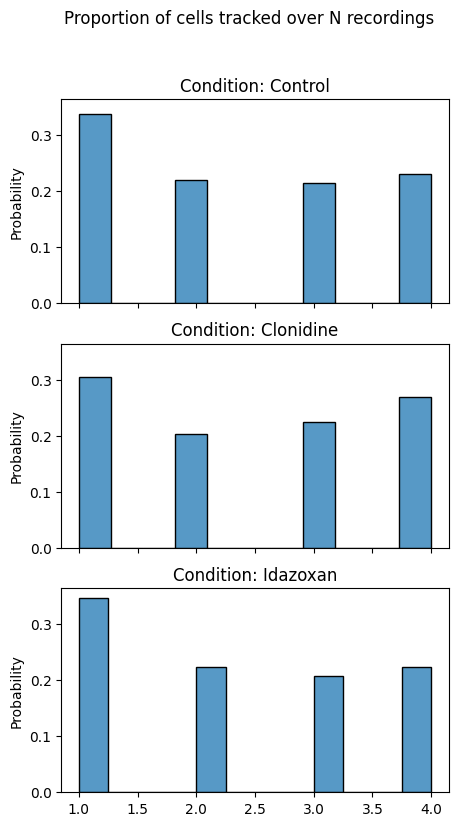

In [17]:
fig, axes = plt.subplots(3, 1, figsize = (5, 9), sharex = True, sharey = True)
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[0])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[0], stat = 'probability')
axes[0].set_title(f'Condition: {conditions[0]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[1])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[1], stat = 'probability')
axes[1].set_title(f'Condition: {conditions[1]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[2])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[2], stat = 'probability')
axes[2].set_title(f'Condition: {conditions[2]}')
fig.suptitle("Proportion of cells tracked over N recordings");

Are these counts significantly different between treatments?

In [18]:
#Form contingency tables
contingencies = np.zeros((3,4))
for idx in range(3):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[idx])
    csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
    csl_counts = Counter(csl)
    csl_counts_ = [csl_counts[k] for k in range(1,5)]
    contingencies[idx,:] = csl_counts_
    
# Two-sample chi-square test
for i,j in combinations(range(3), 2):
    result = chi2_contingency(contingencies[[i,j],:])
    print(f'Chi2 test {conditions[i]} vs {conditions[j]}: {result[1]}')

Chi2 test Control vs Clonidine: 0.251428024411256
Chi2 test Control vs Idazoxan: 0.9543388503945165
Chi2 test Clonidine vs Idazoxan: 0.06222641610595609


*Not* significantly different.

## How many cells are matched, at all, per session?

Now, for each pair or recordings, what proportion of cells are matched between the recordings?

In [23]:
matching_matrix = np.zeros((3, 2, 4, 4))

for c_i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for a_j, animal in enumerate(animals):
        animal_stats = np.stack(cell_stats[animal].values())

        #Of all cells present in s1, how many are present in s2?
        for s1, s2 in product(range(4), range(4)):
            if s1 == s2:
                matching_matrix[c_i, a_j, s1, s2] = 0
                continue
            a_stats = animal_stats[animal_stats[:,s1] == 1, s2]
            matching_matrix[c_i, a_j, s1, s2] = a_stats.sum()/a_stats.shape[0]
            
# find minimum of minima & maximum of maxima
minmin = np.min(matching_matrix)
maxmax = np.max(matching_matrix)

#Plot mean proportion as a function of days from the recording
#Take mean over animals
mean_matching_matrix = np.mean(matching_matrix, axis = 1)

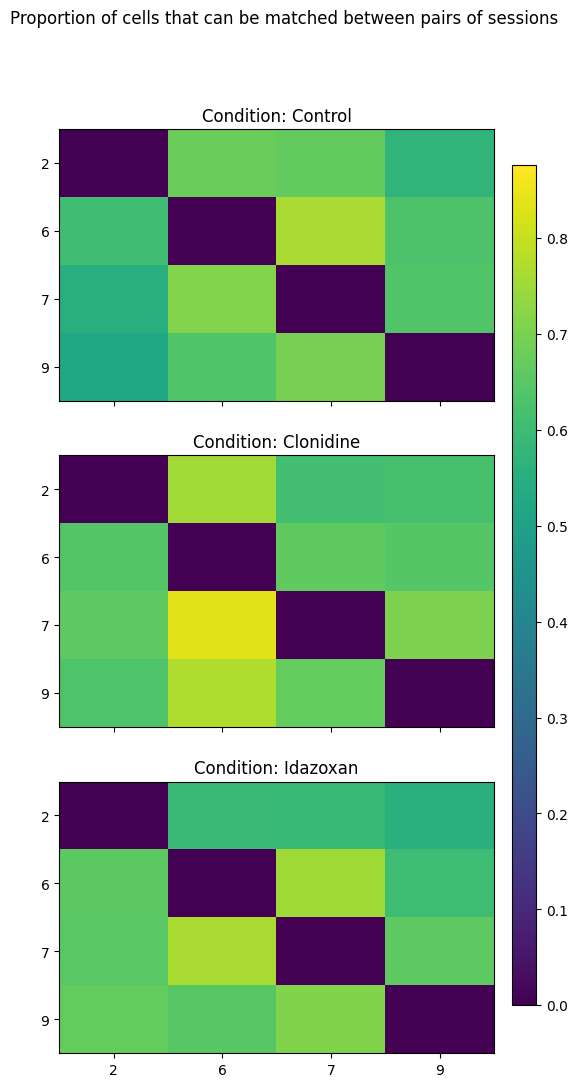

In [24]:
fig, axes = plt.subplots(3,1, figsize = (6,12), sharex = True, sharey = True)
for i in product(range(3)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    ims = axes[i].imshow(mean_matching_matrix[i,:,:].squeeze(), vmin = minmin, vmax = maxmax, aspect = 'auto')
    axes[i].set_xticks(range(4))
    axes[i].set_xticklabels(sessions)
    axes[i].set_yticks(range(4))
    axes[i].set_yticklabels(sessions)
    title = f'Condition: {conditions[i]}'
    axes[i].set_title(title)
fig.suptitle("Proportion of cells that can be matched between pairs of sessions");
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(ims, cax=cbar_ax);

Just visual inspection -- no obvious strong treatment effects

### Null-distribution for number of cell categories

Here we:
* Assume responsiveness only occurs by chance (alpha = 0.05)
* Assign cells randomly to be responsive or not to given condition
* Categorize into classes
* Do this a number of times
* How many cells do we expect to be classified as 'rewarded' by chance alone?
* Compute p-values for classification of cell

Imports

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import combinations, product
from collections import defaultdict
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 

In [ ]:

sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/explore2.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()
n_cond = len(conditions)
n_animals = 3

In [ ]:
def classify_cell(df, idx):
    row = df.iloc[idx]
    tp = 'Non-responsive'
    if ((row.ReSpout_pos == True) or (row.ReSpout_neg == True) or (row.ReMid_pos == True) or (row.ReMid_neg == True)) and \
        ((row.UnSpout_pos == False) or (row.UnSpout_neg == False) or (row.UnMid_pos == False) or (row.UnMid_neg == False)):
        tp = 'Rewarded'
    if ((row.UnSpout_pos == True) or (row.UnSpout_neg == True) or (row.UnMid_pos == True) or (row.UnMid_neg == True)) and \
        ((row.ReSpout_pos == False) or (row.ReSpout_neg == False) or (row.ReMid_pos == False) or (row.ReMid_neg == False)):
        tp = 'UnRewarded'

    return tp

In [ ]:
stats = df.groupby(['treatment', 'Animal', 'Session', 'CellType']).count()['recording']
stats = stats.reset_index()
treatments = conditions
for treat in treatments:
    animals = stats.loc[stats.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            this_cell_sum = stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"].sum()
            stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "cell_prob"] = \
                stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"]/this_cell_sum

In [ ]:
alpha = 0.05
df_null = df.copy()
N_reps = 100

# non_responsive_props = defaultdict(dict)
# rewarded_props = defaultdict(dict)
# unrewarded_props = defaultdict(dict)
sample_cols = ['ReSpout_pos','ReSpout_neg','UnSpout_pos','UnSpout_neg',	'ReMid_pos', 'ReMid_neg', 'UnMid_pos', 'UnMid_neg']

resampling_results = pd.DataFrame(columns = ['treatment', 'animal', 'session', 'celltype', 'p-val'])

for treat in conditions:
    animals = df_null.loc[df_null.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            df_null_cond = df_null.loc[(df_null['treatment'] == treat) & (df_null['Animal'] == animal) & (df_null['Session'] == session)]
            nr = []
            rr = []
            ur = []
            for rep in range(N_reps):
                df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
                for idx in range(len(df_null_cond)):
                    ct = classify_cell(df_null_cond, idx)
                    df_null_cond.iloc[idx,-1] = ct
                cts = df_null_cond.CellType.value_counts()/len(df_null_cond)
                nr.append(cts['Non-responsive'])
                rr.append(cts['Rewarded'])
                ur.append(cts['UnRewarded'])
            try:
                p_nr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Non-responsive'), 'cell_prob'].values[0]
                p_rr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Rewarded'), 'cell_prob'].values[0]
                p_ur = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Unrewarded'), 'cell_prob'].values[0]
            except IndexError: 
                print("Skipping", treat, animal, session)
                continue
            pval_nr = sum(p_nr < np.array(nr))/N_reps
            pval_ur = sum(p_ur < np.array(ur))/N_reps
            pval_rr = sum(p_rr < np.array(rr))/N_reps
            newrow1 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Non-responsive'], 'p-val': [pval_nr]})
            newrow2 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Rewarded'], 'p-val': [pval_rr]})
            newrow3 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['UnRewarded'], 'p-val': [pval_ur]})
            resampling_results = pd.concat([resampling_results, newrow1, newrow2, newrow3], axis = 0)

/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Skipping Clonidine 83 6


/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Skipping Idazoxan 4 6


/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

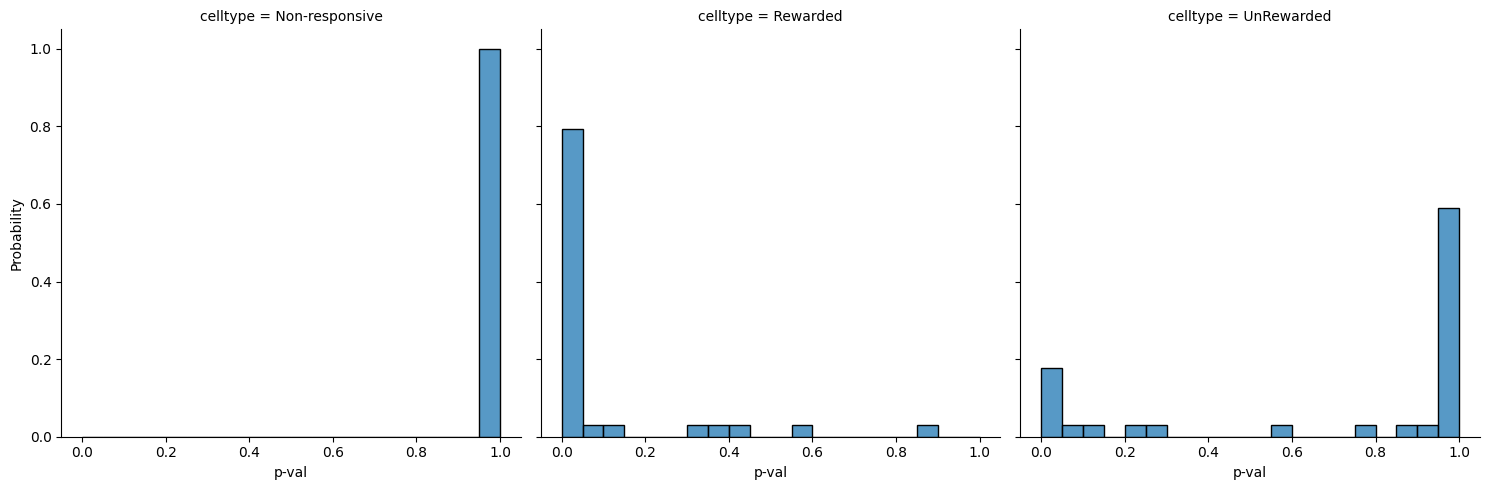

In [ ]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', bins = 20, stat = 'probability', common_norm = False)

Observed, many *more* rewarded cells than expected based on alpha level. Not the same overabundance in unrewarded cells. Gives a way to interpret the number of responsive cells as high or not.

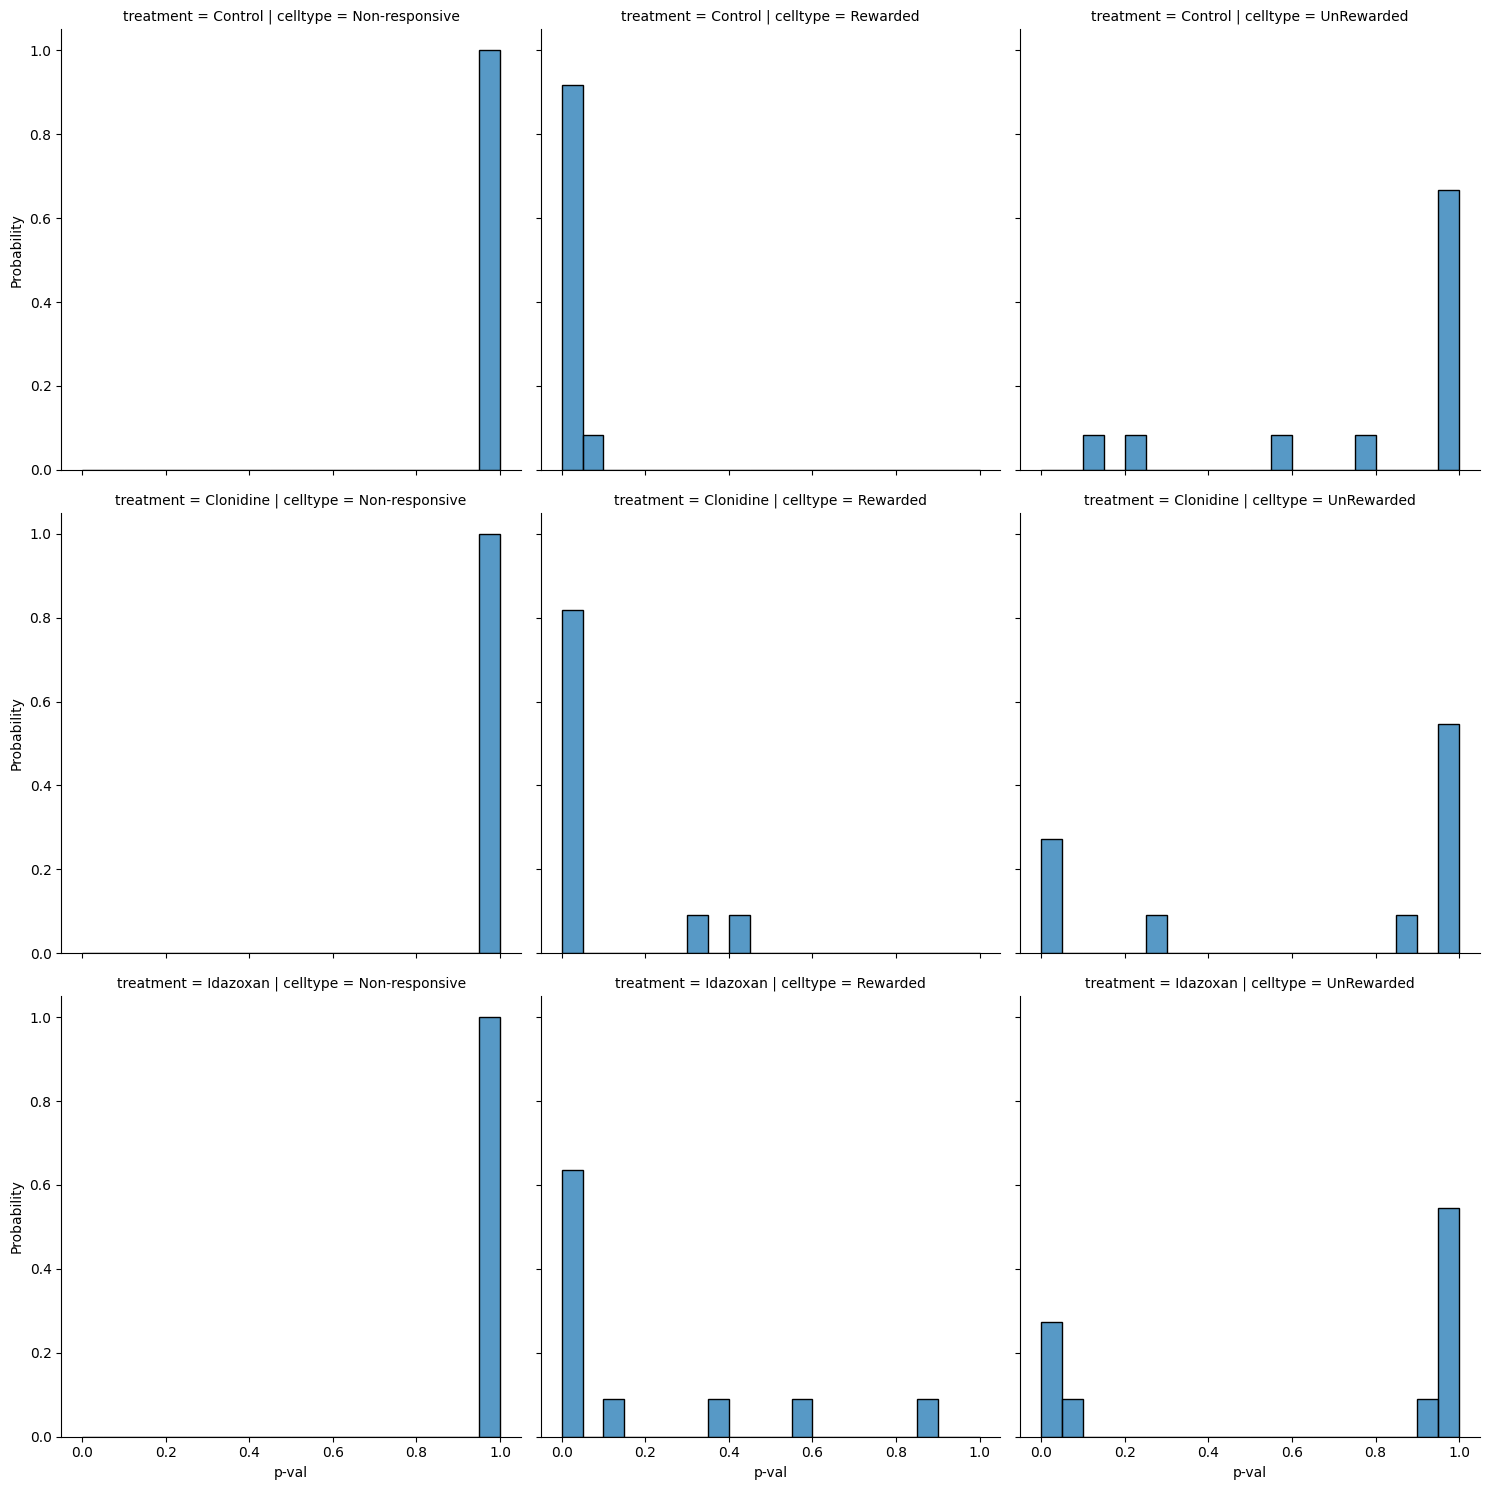

In [ ]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', row = 'treatment', bins = 20, stat = 'probability', common_norm = False)

Baseline probabilities or two cell types, expected purely by simple definition

Expected counts for non-responsive
`(1-alpha)^8`

Expected counts for rewarded:
`1-(1-alpha)^4`

Expected counts for unrewarded:
`1-(1-alpha)^4`

In [ ]:
non_responsive_prob = (1-alpha)**8
rewarded_prob = 1-(1-alpha)**4

In [ ]:
print("Expected rewarded cell proportion by chance alone:", rewarded_prob)
print("Expected unrewarded cell proportion by chance alone:", rewarded_prob)
print("Expected non-responsive cell proportion by chance alone:", non_responsive_prob)

Expected rewarded cell proportion by chance alone: 0.18549375000000012
Expected unrewarded cell proportion by chance alone: 0.18549375000000012
Expected non-responsive cell proportion by chance alone: 0.6634204312890623
